<a href="https://colab.research.google.com/github/JimmyLiu8351/liulabtracking/blob/main/eye_test_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import cv2
import numpy as np

from google.colab.patches import cv2_imshow
from PIL import Image

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [70]:
def gradx(img):
    img = img.astype('int')
    rows, cols = img.shape
    # Use hstack to add back in the columns that were dropped as zeros
    return np.hstack( (np.zeros((rows, 1)), (img[:, 2:] - img[:, :-2])/2.0, np.zeros((rows, 1))) )

In [71]:
def grady(img):
    img = img.astype('int')
    rows, cols = img.shape
    # Use vstack to add back the rows that were dropped as zeros
    return np.vstack( (np.zeros((1, cols)), (img[2:, :] - img[:-2, :])/2.0, np.zeros((1, cols))) )

In [72]:
#Performs fast radial symmetry transform
#img: input image, grayscale
#radii: integer value for radius size in pixels (n in the original paper); also used to size gaussian kernel
#alpha: Strictness of symmetry transform (higher=more strict; 2 is good place to start)
#beta: gradient threshold parameter, float in [0,1]
#stdFactor: Standard deviation factor for gaussian kernel
#mode: BRIGHT, DARK, or BOTH
def frst(img, radii, alpha, beta, stdFactor, mode='BOTH'):
    mode = mode.upper()
    assert mode in ['BRIGHT', 'DARK', 'BOTH']
    dark = (mode == 'DARK' or mode == 'BOTH')
    bright = (mode == 'BRIGHT' or mode == 'BOTH')

    workingDims = tuple((e + 2*radii) for e in img.shape)

    #M and O working matrices
    O_n = np.zeros(workingDims, np.int16)
    M_n = np.zeros(workingDims, np.int16)

    #Calculate gradients
    gx = gradx(img)
    gy = grady(img)

    #Find gradient vector magnitude
    gnorms = np.sqrt( np.add( np.multiply(gx, gx) , np.multiply(gy, gy) ) )

    #Use beta to set threshold - speeds up transform significantly
    gthresh = np.amax(gnorms)*beta

    #Find x/y distance to affected pixels
    gpx = np.multiply(np.divide(gx, gnorms, out=np.zeros(gx.shape), where=gnorms!=0), radii).round().astype(int);
    gpy = np.multiply(np.divide(gy, gnorms, out=np.zeros(gy.shape), where=gnorms!=0), radii).round().astype(int);

    #Iterate over all pixels (w/ gradient above threshold)
    for coords, gnorm in np.ndenumerate(gnorms):
        if gnorm > gthresh:
            i, j = coords
            #Positively affected pixel
            if bright:
                ppve = (i+gpy[i,j]+radii, j+gpx[i,j]+radii)
                O_n[ppve] += 1
                M_n[ppve] += gnorm
            #Negatively affected pixel
            if dark:
                pnve = (i-gpy[i,j]+radii, j-gpx[i,j]+radii)
                O_n[pnve] -= 1
                M_n[pnve] -= gnorm

    

    #Abs and normalize O matrix
    O_n = np.abs(O_n)
    O_n = O_n / float(np.amax(O_n))

    #Normalize M matrix
    M_max = float(np.amax(np.abs(M_n)))
    M_n = M_n / M_max

    #Elementwise multiplication
    F_n = np.multiply(np.power(O_n, alpha), M_n)

    #Gaussian blur
    kSize = int( np.ceil( radii / 2 ) )
    kSize = kSize + 1 if kSize % 2 == 0 else kSize

    S = cv2.GaussianBlur(F_n, (kSize, kSize), int( radii * stdFactor ))
    
    return S[radii:-radii,radii:-radii]

In [73]:
# opening the video in videocapture

file_path = "/content/gdrive/MyDrive/mouse_eye_tracking/fixedSFblink.avi"
vidcap = cv2.VideoCapture(file_path)

#file_path = "/content/gdrive/MyDrive/mouse_eye_tracking/Black_Circle.png"
#frame = cv2.imread(file_path)
#cv2_imshow(frame)
#print(frame.shape)

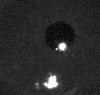

In [84]:
# reading the frame from video

ret, frame = vidcap.read()
for i in range(2000):
    ret, frame = vidcap.read()
frame = frame[80:175, 100:200]
cv2_imshow(frame)

In [75]:
# Detector initialization
detector = cv2.SimpleBlobDetector_create()

[]


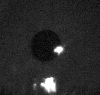

In [79]:
# Simple blob detection

gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#test_circle = cv2.imread("/content/gdrive/MyDrive/mouse_eye_tracking/Black_Circle.png")
#cv2_imshow(test_circle)

keypoints = detector.detect(gray_frame)
print(keypoints)


frame_with_keypoints = cv2.drawKeypoints(gray_frame, keypoints, np.array([]), (0, 0, 255),
                                            cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2_imshow(frame_with_keypoints)



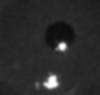

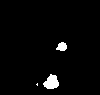

In [85]:
# thresholding the corneal reflections
#gray_frame = cv2.cvtColor(test_circle, cv2.COLOR_BGR2GRAY)
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
blur_frame = cv2.GaussianBlur(gray_frame, (5, 5), sigmaX=0, sigmaY=0)

cv2_imshow(blur_frame)

ret, thresh_frame = cv2.threshold(blur_frame, 100, 255, cv2.THRESH_BINARY)
#th3 = cv2.adaptiveThreshold(blur_frame, 220, cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV, 5, 2)
cv2_imshow(thresh_frame)

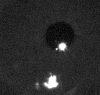

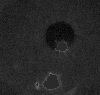

In [86]:
# applying the mean color to reflection areas
mean = np.mean(gray_frame)

mean_frame = gray_frame.copy()

for (x, y), value in np.ndenumerate(thresh_frame):
    if value > 0:
        mean_frame[x, y] = mean

cv2_imshow(gray_frame)
cv2_imshow(mean_frame)

(30, 60)


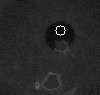

In [88]:
# running frst on image

#ten = frst(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), 10, 2, 0.2, 0, mode='DARK')
#twelve = frst(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), 12, 2, 0.2, 0, mode='DARK')
#fourteen = frst(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), 14, 2, 0.2, 0, mode='DARK')

ten = frst(mean_frame, 10, 2, 0.2, 0, mode='DARK')
twelve = frst(mean_frame, 12, 2, 0.2, 0, mode='DARK')
fourteen = frst(mean_frame, 14, 2, 0.2, 0, mode='DARK')

arr2D = np.add(ten, twelve, fourteen)

eye = np.unravel_index(arr2D.argmin(), arr2D.shape)
print(eye)
cv2.circle(mean_frame, (eye[1], eye[0]), 5, (255,255,255))
cv2_imshow(mean_frame)

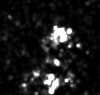

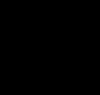

In [89]:
cv2_imshow(np.multiply(arr2D, -10000))
cv2_imshow(np.multiply(arr2D, 10000))